In [2]:
import pandas as pd

In [4]:
re = pd.read_csv("/content/online_retail_II.csv")

In [5]:
re.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [15]:
print(re.shape)
print(re.columns)
print(re.dtypes)

(1067371, 8)
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


In [10]:
re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [16]:
re['InvoiceDate'] = pd.to_datetime(re['InvoiceDate'])

In [17]:
re.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [18]:
re = re.dropna(subset=['Customer ID'])

In [19]:
print(re.shape)

(824364, 8)


In [21]:
re = re[re['Quantity'] > 0]

In [22]:
re= re[re['Price']>0]

In [23]:
re['Revenue'] = re['Quantity']*re['Price']

In [24]:
print(re.shape)

(805549, 9)


In [25]:
total_revenue =re['Revenue'].sum()

In [26]:
total_revenue

np.float64(17743429.178000003)

In [28]:
total_customers= re['Customer ID'].nunique()

In [29]:
total_customers

5878

In [30]:
total_orders= re['Invoice'].nunique()

In [31]:
total_orders

36969

<Axes: xlabel='YearMonth'>

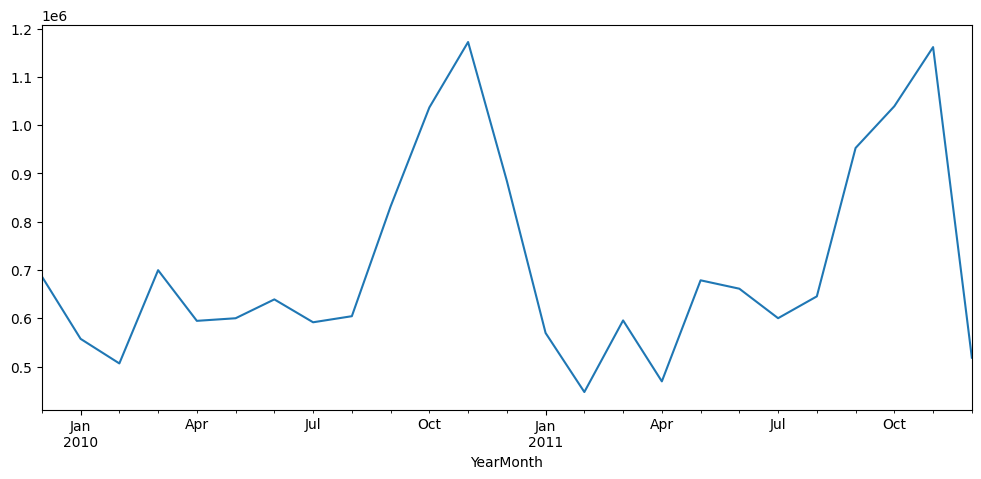

In [38]:
re['YearMonth'] = re['InvoiceDate'].dt.to_period('M')

monthly_revenue = re.groupby('YearMonth')['Revenue'].sum()
monthly_revenue.sort_index().plot(figsize=(12,5))

In [37]:
country_revenue = (
    re.groupby('Country')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

country_revenue

,Revenue
Country,
United Kingdom,1.472315e+07
EIRE,6.216311e+05
Netherlands,5.542323e+05
Germany,4.312625e+05
France,3.552575e+05
Australia,1.699681e+05
Spain,1.091785e+05
Switzerland,1.003653e+05
Sweden,9.154972e+04


In [34]:
snapshot_date = re['InvoiceDate'].max() + pd.Timedelta(days=1)


In [36]:
rfm = re.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Revenue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [40]:
rfm.describe()

,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000
mean,201.331916,6.289384,3018.616737
std,209.338707,13.009406,14737.731040
min,1.000000,1.000000,2.950000
25%,26.000000,1.000000,348.762500
50%,96.000000,3.000000,898.915000
75%,380.000000,7.000000,2307.090000
max,739.000000,398.000000,608821.650000


In [41]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,255
12347.0,2,8,5633.32,5,4,5,545
12348.0,75,5,2019.40,3,4,4,344
12349.0,19,4,4428.69,5,3,5,535
12350.0,310,1,334.40,2,1,2,212


In [42]:
def segment_customer(row):
    if row['RFM_Score'] == '555':
        return 'Champions'
    elif row['R_score'] >= 4 and row['F_score'] >= 4:
        return 'Loyal Customers'
    elif row['R_score'] <= 2 and row['F_score'] >= 4:
        return 'At Risk'
    elif row['M_score'] >= 4:
        return 'Big Spenders'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm['Segment'].value_counts()

,count
Segment,
Others,3219
Loyal Customers,1008
Big Spenders,824
Champions,474
At Risk,353


In [43]:
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
segment_revenue

,Monetary
Segment,
Champions,8356881.904
Loyal Customers,3936256.751
Big Spenders,2834206.437
Others,1489853.184
At Risk,1126230.902


In [44]:
segment_revenue / segment_revenue.sum() * 100

,Monetary
Segment,
Champions,47.098460
Loyal Customers,22.184307
Big Spenders,15.973273
Others,8.396647
At Risk,6.347313


In [45]:
rfm['Segment'].value_counts()

,count
Segment,
Others,3219
Loyal Customers,1008
Big Spenders,824
Champions,474
At Risk,353


In [46]:
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

segment_revenue

,Monetary
Segment,
Champions,8356881.904
Loyal Customers,3936256.751
Big Spenders,2834206.437
Others,1489853.184
At Risk,1126230.902


In [47]:
segment_percentage = segment_revenue / segment_revenue.sum() * 100

segment_percentage

,Monetary
Segment,
Champions,47.098460
Loyal Customers,22.184307
Big Spenders,15.973273
Others,8.396647
At Risk,6.347313


In [48]:
rfm_sorted = rfm.sort_values('Monetary', ascending=False)
top_20_percent = int(len(rfm_sorted) * 0.2)

top_20_revenue = rfm_sorted.head(top_20_percent)['Monetary'].sum()
total_revenue = rfm_sorted['Monetary'].sum()

(top_20_revenue / total_revenue) * 100

np.float64(77.24241516962984)

In [49]:
re.to_csv("cleaned_ecommerce_data.csv", index=False)

In [51]:
rfm.to_csv("rfm.csv",index = False)

In [52]:
rfm.reset_index(inplace=True)

In [53]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
0,12346.0,326,12,77556.46,2,5,5,255,At Risk
1,12347.0,2,8,5633.32,5,4,5,545,Loyal Customers
2,12348.0,75,5,2019.40,3,4,4,344,Big Spenders
3,12349.0,19,4,4428.69,5,3,5,535,Big Spenders
4,12350.0,310,1,334.40,2,1,2,212,Others


In [54]:
rfm.to_csv("rfm.csv",index = False)